<a href="https://colab.research.google.com/github/zbj3ji/zbj3ji/blob/main/Classification_red_green_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple classification problem inspired by following Kaggle Data set

VCoR (Vehicle Color Recognition) Dataset
Vehicle Color Recognition

Dataset source:
https://www.kaggle.com/datasets/landrykezebou/vcor-vehicle-color-recognition-dataset

# Here is an example how to download Kaggle data set and use it in Google Colab
Download Data

!kaggle competitions download -c 'name-of-competition'

Use unzip command to unzip the data:

For example,

Create a directory named train,

!mkdir train

unzip train data there,

!unzip train.zip -d train 

In [50]:
!pip install -q kaggle
from google.colab import files 

In [ ]:
#upload JSON from Kaggle
files.upload()

In [52]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Here we list comeptition datasets

In [53]:
!kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           4326        139  1.0              
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          20812        562  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           3038         75  1.0              
fuarresvij/gdp-growth-around-the-globe                      

And here we just use a normal dataset from the top of the page by downloading it into Colab

In [ ]:
!kaggle datasets download landrykezebou/vcor-vehicle-color-recognition-dataset

We are going to unpack the content into our directories now

In [ ]:
# so let's create directories first
!mkdir /content/detection
!mkdir /content/detection/train
!mkdir /content/detection/val
!mkdir /content/detection/test
!unzip /content/vcor-vehicle-color-recognition-dataset.zip

In [56]:
# here we move just green and red ones into our "detection" folder
!cp -r "/content/train/green" "/content/detection/train"
!cp -r "/content/val/green" "/content/detection/val"
!cp -r "/content/test/green" "/content/detection/test"

!cp -r "/content/train/red" "/content/detection/train"
!cp -r "/content/val/red" "/content/detection/val"
!cp -r "/content/test/red" "/content/detection/test"


# Our code related to classification starts from here
As usually we start by loading some libraries

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_datasets as tfds
import os
import PIL
from tensorflow.keras import layers

In [58]:
# we define our working directories
TRAIN_PATH = '/content/detection/train'
VAL_PATH = '/content/detection/val'
TEST_PATH = '/content/detection/test'

# we want to predict just green or red cars
BIN_CLASS_OK = 'green'
BIN_CLASS_NOK = 'red'

Files in the folder 562


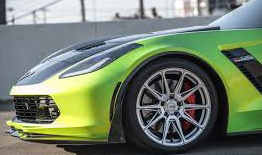

In [59]:
# load filenames into list
train_lst_ok = os.listdir(os.path.join(TRAIN_PATH, BIN_CLASS_OK))
train_lst_nok = os.listdir(os.path.join(TRAIN_PATH, BIN_CLASS_NOK))
# remove '/' dir from the list 
train_lst_ok = train_lst_ok[1:]
train_lst_nok = train_lst_nok[1:]

# print a sample
SAMPLE = 0

# OK image = green car
img_path_train_ok = os.path.join(TRAIN_PATH, BIN_CLASS_OK, train_lst_ok[SAMPLE])
#print(img_path_train_ok) 

# load one image from training set
if len(train_lst_ok)>0:
  #PIL.Image.open(img_path)
  print('Files in the folder', len(train_lst_ok))

PIL.Image.open(img_path_train_ok)

Files in the folder 636


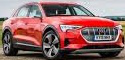

In [60]:
# NOK image = red car
img_path_train_nok = os.path.join(TRAIN_PATH, BIN_CLASS_NOK, train_lst_nok[SAMPLE])
#print(img_path_train_nok) 

# load one image from training set
if len(train_lst_nok)>0:
  #PIL.Image.open(img_path_train_nok)
  print('Files in the folder', len(train_lst_nok))

PIL.Image.open(img_path_train_nok)

#print(train_lst_ok)

In [61]:
# here we set some parameters

BATCH_SIZE = 30
# fixed width/height to reshape our images into same resolution/dimension as an input of our CNN
IMG_HEIGHT = 80
IMG_WIDTH = IMG_HEIGHT * 2

# not used in theis tutorial
#resize_and_rescale = tf.keras.Sequential([
#  layers.Resizing(IMG_WIDTH, IMG_HEIGHT),
#  layers.Rescaling(1./255)
#])

In [62]:
# Assign training and validation set directories
base_dir = '/content/detection'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with training cat pictures
train_ok_dir = os.path.join(train_dir, 'green')

# Directory with training dog pictures
train_nok_dir = os.path.join(train_dir, 'red')

# Directory with validation cat pictures
validation_ok_dir = os.path.join(validation_dir, 'green')

# Directory with validation dog pictures
validation_nok_dir = os.path.join(validation_dir, 'red')

In [63]:
# we just check what we assigned above
print(base_dir)
print(train_dir)
print(validation_dir)
print(train_ok_dir)
print(train_nok_dir)
print(validation_ok_dir)
print(validation_nok_dir)

/content/detection
/content/detection/train
/content/detection/val
/content/detection/train/green
/content/detection/train/red
/content/detection/val/green
/content/detection/val/red


# Image Data Generator
Image augmentation is already considered, so we use our real images for the augmentation in PC memory (fliping, rotation, etc.) to virtually enlarge our small dataset to achive better results

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    rescale=1./255)

# Flow training images in batches of BATCH_SIZE using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(IMG_WIDTH, IMG_HEIGHT),  # All images will be resized to 150x150
        batch_size=BATCH_SIZE,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of BATCH_SIZE using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 1200 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


This is our model architecture, if this is **binary classification problem** we use 'Dense(1, activation='sigmoid')' as our last layer + 'binary_crossentropy' as our loss function. 
In case we'd like to compare more than 2 classes (e.g. to predict other colors from the dataset) we change here our last layer by this: 'Dense(our_classes, activation='softmax')' + loss will be here 'sparse_crossentropy'
'our_class' will be then the amount of classes we use e.g. if we want to have 5 different car colors then this number will be 5.

In [65]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      #resize_and_rescale(input_shape=(150, 150, 3)),
      #tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['accuracy'])
  
  return model

# Our CNN model

In [66]:
# Constant for epochs
EPOCHS = 20

# Create a new model
model = create_model()

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=40,  
      # 1200 = 30 * 40 
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=7,
      # 210 = 30 * 7
      verbose=2)

Epoch 1/20
40/40 - 11s - loss: 0.5117 - accuracy: 0.7492 - val_loss: 0.2905 - val_accuracy: 0.8762 - 11s/epoch - 271ms/step
Epoch 2/20
40/40 - 9s - loss: 0.2020 - accuracy: 0.9267 - val_loss: 0.0409 - val_accuracy: 0.9952 - 9s/epoch - 225ms/step
Epoch 3/20
40/40 - 9s - loss: 0.1233 - accuracy: 0.9442 - val_loss: 0.0372 - val_accuracy: 0.9905 - 9s/epoch - 225ms/step
Epoch 4/20
40/40 - 10s - loss: 0.1060 - accuracy: 0.9583 - val_loss: 0.0199 - val_accuracy: 0.9952 - 10s/epoch - 258ms/step
Epoch 5/20
40/40 - 9s - loss: 0.1089 - accuracy: 0.9625 - val_loss: 0.0306 - val_accuracy: 0.9905 - 9s/epoch - 224ms/step
Epoch 6/20
40/40 - 9s - loss: 0.0725 - accuracy: 0.9808 - val_loss: 0.0358 - val_accuracy: 1.0000 - 9s/epoch - 224ms/step
Epoch 7/20
40/40 - 9s - loss: 0.0672 - accuracy: 0.9817 - val_loss: 0.0215 - val_accuracy: 0.9905 - 9s/epoch - 225ms/step
Epoch 8/20
40/40 - 11s - loss: 0.0522 - accuracy: 0.9808 - val_loss: 0.0087 - val_accuracy: 0.9952 - 11s/epoch - 275ms/step
Epoch 9/20
40/40 -

We plot our learnng procedure to check overfitting/underfitting, progress, etc.

In [67]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

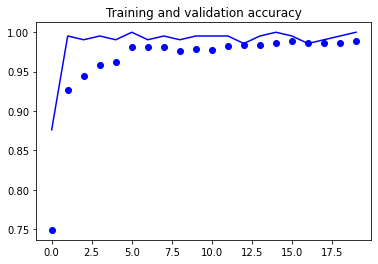

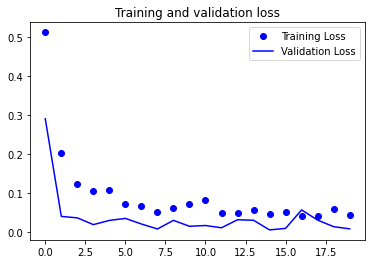

In [68]:
# Plot training results
plot_loss_acc(history)

# Prediction test by using testing data
Here we use our test green car list to check our predictions

In [ ]:
green_test = os.listdir('/content/detection/test/green')
green_test

In [ ]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

#uploaded=files.upload()
cntr_red = cntr_green = 0
bad_decision_files = []
for fn in green_test:
 
  # predicting images
  path='/content/test/green/' + fn
  img=load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=20)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a red car")
    bad_decision_files.append(fn)
    cntr_red += 1
  else:
    print(fn + " is a green car")
    cntr_green += 1


print('Guest green ones:', cntr_green)
print('Guest red ones:', cntr_red) #bb09c84231.jpg
print('Failure rate:', (cntr_red/(cntr_green + cntr_red))*100 )

print('The list of bad decision files:', bad_decision_files)

/content/detection/test/green/7ffa14bb51.jpg


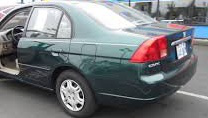

In [71]:
# Let's have a look, how the bad decision images look like

if len(bad_decision_files)>0:

  img_path = os.path.join(TEST_PATH, BIN_CLASS_OK, bad_decision_files[0])
  print(img_path) 

PIL.Image.open(img_path)



Let's check our red car testing list

In [ ]:
red_test = os.listdir('/content/detection/test/red')
red_test

In [ ]:
cntr_red = cntr_green = 0
bad_decision_files = []
for fn in red_test:
 
  # predicting images
  path='/content/test/red/' + fn
  img=load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=20)
  
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a red car")
    cntr_red += 1
  else:
    print(fn + " is a green car")
    bad_decision_files.append(fn)
    cntr_green += 1


print('Guest green ones:', cntr_green)
print('Guest red ones:', cntr_red) #bb09c84231.jpg
print('Failure rate:', (cntr_green/(cntr_green + cntr_red))*100 )

print('The list of bad decision files:', bad_decision_files)

And again we check the one where our estimation was wrong

In [74]:
# Let's have a look, how the bad decision images look like

if len(bad_decision_files)>0:

  img_path = os.path.join(TEST_PATH, BIN_CLASS_NOK, bad_decision_files[0])
  print(img_path) 

PIL.Image.open(img_path)

/content/detection/test/red/0c098b9636.jpg


# Conclusion
This works pretty well (~99% accuracy), the pictures with wrong classification are self-explainable. E.g. in red testing set we have also car with totally different color. Because we **didn't clean our data at the very beginning**, solution could be simply to delete such pictures cause it's misleading. So always remember: before any action, check consistency of the input data and clean them accordingly. With bad inputs model will never be good! :)